# Feature Selection
---
In machine learning and statistics, feature selection is the process of selecting a subset of relevant features (variables, predictors) for use in model construction. Feature selection techniques are used for mainly four reasons:
- simplification of models to make them easier to interpret by researchers/users
- shorter training times
- to avoid the curse of dimensionality
- enhanced generalization by reducing overfitting (by reducing variance)

Features gathered from the observation of a phenomenon are not all equally
informative: some of them may be noisy, correlated or irrelevant. Feature
selection aims at selecting a feature set that is relevant for a given task. This
problem is complex and remains an important issue in many domains. 

Contents: 
- [Feature selection by the Boruta Algorithm](#boruta)
- [Feature selection by Random Forest](#random-forest)
- [Feature selection by PCA](#PCA)

In [19]:
len(ts)

88685

In [7]:
# import external modules
import sys, os
ROOT_PATH = os.path.abspath(".").split("src")[0]
module_path = os.path.abspath(os.path.join(ROOT_PATH+"/src/utils/"))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc 
from tabulate import tabulate

import keras
from keras import layers, regularizers, Input, Model
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras import backend as K

import tensorflow as tf
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import functions as f
import dl_functions as dlf
from generators import batch_generator

In [8]:
from cognite.client import CogniteClient
client = CogniteClient(api_key=os.environ['COGNITE_API_SECRET'])

In [6]:
scrubber_file_name = 'PH-ME-P-0152-001'
#scrubber_file_name = 'PH-ME-P-0153-001'
client.files.list_files(name=scrubber_file_name).to_pandas()
client.files.download_file(client.files.list_files(name=scrubber_file_name).to_pandas().id[0])

'https://storage.googleapis.com/cognite-storage/5977964818434649/7888771415910453/PH-ME-P-0153-001?GoogleAccessId=api-service-account@cognitedata-europe-west1-1.iam.gserviceaccount.com&Expires=1557744454&Signature=KQyIvB5vhfQGBrPol0SaH8pkEKuDJMcfF3laYxwr5vl%2BPF5MXdqJ5XdoAyvYwDsok3XOtvzR6TSrIkpij9pM1yG3jSY%2FPOr9LQe19gQX%2Fk7%2FnOepK%2B%2FFwF3I7SQDlQEMWjPvNZ28eLSfVv9TNQAkOsrIVGQY6ZX08T6vpKaNiQDaNN%2F6Qx5soWUQGEoVmYMDumEIk2NVXZo3nOf7FR1nPOLW7Pzd%2BK%2FIGCcslq112v3LbG3A2i%2BikH3zjmHEWn2M57JYkrX8hWet44xtlKj7r5%2FWLkd%2FSU4WS3itEk0m6auqAN7ZbsST%2FdzYETJCcgK3xz770v5qP9Tm9jk%2FaafPvA%3D%3D'

**Loading the data**

In [10]:
df_train, df_valid, df_test = f.load_data()
#df_train, df_valid, df_test = f.load_data(dummy_data=True, dummy_obs=5000)
stats, ts, ts_train, ts_valid, ts_test = f.load_metadata()

# split datasets into features and targets
x_train, y_train = f.split_dataset(df_train.values, delay=1)
x_valid, y_valid = f.split_dataset(df_valid.values, delay=1)
x_test, y_test = f.split_dataset(df_test.values, delay=1)

# metadata
target_tags = df_train.columns.values[:3]
feature_tags = df_train.columns.values[3:]
target_stds = stats.loc[target_tags,"Std"].values

In [14]:
all_tags = pd.read_csv(ROOT_PATH + "data/metadata/tags/all_tags_chosen.csv", sep=";")

In [16]:
len(all_tags)

146

<a class="anchor" id="boruta"></a>

---
## (1) Feature Selection by the  Boruta Algorithm

Boruta is an all relevant feature selection method, while most other are minimal optimal; this means it tries to find all features carrying information usable for prediction, rather than finding a possibly compact subset of features on which some classifier has a minimal error. The Boruta algorithm is a Random Forest classification algorithm that we'll use to perform a top-down search for relevant features by comparing original attributes' importance with importance achievable at random, estimated using their permuted copies, and progressively eliminating irrelevant features.

---

In [3]:
def run_boruta(X, y, ntrees=500):
    forest = RandomForestRegressor(n_jobs=-1, max_depth=5, random_state=SEED)
    feat_selector = BorutaPy(forest, n_estimators=ntrees, verbose=2, random_state=SEED, max_iter=100)
    feat_selector.fit(X,y)
    
    return forest, feat_selector

We must run a separate run for each of our targets. Finally, all "confirmed" tags will be concatenated together and represent the chosen features. 

In [4]:
flow_forest, flow_boruta = run_boruta(x_train, y_train[:,0])

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	95
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	95
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	95
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	95
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	95
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	95
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	95
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	21
Tentative: 	20
Rejected: 	54


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	9 / 100
Confirmed: 	21
Tentative: 	20
Rejected: 	54


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	10 / 100
Confirmed: 	21
Tentative: 	20
Rejected: 	54


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	11 / 100
Confirmed: 	21
Tentative: 	20
Rejected: 	54


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	12 / 100
Confirmed: 	21
Tentative: 	17
Rejected: 	57


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	13 / 100
Confirmed: 	21
Tentative: 	17
Rejected: 	57


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	14 / 100
Confirmed: 	21
Tentative: 	17
Rejected: 	57


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	15 / 100
Confirmed: 	21
Tentative: 	17
Rejected: 	57


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	16 / 100
Confirmed: 	21
Tentative: 	14
Rejected: 	60


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	17 / 100
Confirmed: 	21
Tentative: 	14
Rejected: 	60


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	18 / 100
Confirmed: 	21
Tentative: 	14
Rejected: 	60


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	19 / 100
Confirmed: 	21
Tentative: 	14
Rejected: 	60


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	20 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	21 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	22 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	23 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	24 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	25 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	26 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	27 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	28 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	29 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	30 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	31 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	32 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	33 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	34 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	35 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	36 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	37 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	38 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	39 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	40 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	41 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	42 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	43 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	44 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	45 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	46 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	47 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	48 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	49 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	50 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	51 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	52 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	53 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	54 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	55 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	56 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	57 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	58 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	59 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	60 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	61 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	62 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	63 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	64 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	65 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	66 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	67 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	68 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	69 / 100
Confirmed: 	21
Tentative: 	13
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	70 / 100
Confirmed: 	22
Tentative: 	12
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	71 / 100
Confirmed: 	22
Tentative: 	12
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	72 / 100
Confirmed: 	22
Tentative: 	12
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	73 / 100
Confirmed: 	22
Tentative: 	12
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	74 / 100
Confirmed: 	22
Tentative: 	12
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	75 / 100
Confirmed: 	22
Tentative: 	12
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	76 / 100
Confirmed: 	22
Tentative: 	12
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	77 / 100
Confirmed: 	23
Tentative: 	11
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	78 / 100
Confirmed: 	23
Tentative: 	11
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	79 / 100
Confirmed: 	23
Tentative: 	11
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	80 / 100
Confirmed: 	23
Tentative: 	11
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	81 / 100
Confirmed: 	23
Tentative: 	11
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	82 / 100
Confirmed: 	23
Tentative: 	11
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	83 / 100
Confirmed: 	23
Tentative: 	11
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	84 / 100
Confirmed: 	23
Tentative: 	11
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	85 / 100
Confirmed: 	23
Tentative: 	11
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	86 / 100
Confirmed: 	23
Tentative: 	11
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	87 / 100
Confirmed: 	23
Tentative: 	11
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	88 / 100
Confirmed: 	23
Tentative: 	11
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	89 / 100
Confirmed: 	23
Tentative: 	11
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	90 / 100
Confirmed: 	23
Tentative: 	11
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	91 / 100
Confirmed: 	23
Tentative: 	11
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	92 / 100
Confirmed: 	23
Tentative: 	11
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	93 / 100
Confirmed: 	23
Tentative: 	11
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	94 / 100
Confirmed: 	23
Tentative: 	11
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	95 / 100
Confirmed: 	24
Tentative: 	10
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	96 / 100
Confirmed: 	24
Tentative: 	10
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	97 / 100
Confirmed: 	24
Tentative: 	10
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	98 / 100
Confirmed: 	24
Tentative: 	10
Rejected: 	61
Iteration: 	99 / 100
Confirmed: 	24
Tentative: 	10
Rejected: 	61


BorutaPy finished running.

Iteration: 	100 / 100
Confirmed: 	24
Tentative: 	6
Rejected: 	61


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


In [5]:
temp_forest, temp_boruta = run_boruta(x_train, y_train[:,1])

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	95
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	95
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	95
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	95
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	95
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	95
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	95
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	9 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	10 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	11 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	12 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	13 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	14 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	15 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	16 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	17 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	18 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	19 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	20 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	21 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	22 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	23 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	24 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	25 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	26 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	27 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	28 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	29 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	30 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	31 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	32 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	33 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	34 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	35 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	36 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	37 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	38 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	39 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	40 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	41 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	42 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	43 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	44 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	45 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	46 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	47 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	48 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	49 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	50 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	51 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	52 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	53 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	54 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	55 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	56 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	57 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	58 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	59 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	60 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	61 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	86
Iteration: 	62 / 100
Confirmed: 	9
Tentative: 	0
Rejected: 	86


BorutaPy finished running.

Iteration: 	63 / 100
Confirmed: 	9
Tentative: 	0
Rejected: 	86


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


In [6]:
pres_forest, pres_boruta = run_boruta(x_train, y_train[:,2])

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	95
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	95
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	95
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	95
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	95
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	95
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	95
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	82


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	9 / 100
Confirmed: 	2
Tentative: 	11
Rejected: 	82


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	10 / 100
Confirmed: 	2
Tentative: 	11
Rejected: 	82


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	11 / 100
Confirmed: 	2
Tentative: 	11
Rejected: 	82


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	12 / 100
Confirmed: 	2
Tentative: 	8
Rejected: 	85


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	13 / 100
Confirmed: 	2
Tentative: 	8
Rejected: 	85


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	14 / 100
Confirmed: 	2
Tentative: 	8
Rejected: 	85


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	15 / 100
Confirmed: 	2
Tentative: 	8
Rejected: 	85


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	16 / 100
Confirmed: 	2
Tentative: 	6
Rejected: 	87


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	17 / 100
Confirmed: 	2
Tentative: 	6
Rejected: 	87


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	18 / 100
Confirmed: 	2
Tentative: 	6
Rejected: 	87


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	19 / 100
Confirmed: 	2
Tentative: 	5
Rejected: 	88


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	20 / 100
Confirmed: 	2
Tentative: 	5
Rejected: 	88


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	21 / 100
Confirmed: 	2
Tentative: 	5
Rejected: 	88


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	22 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	89


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	23 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	89


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	24 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	89


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	25 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	89


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	26 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	89


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	27 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	89


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	28 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	89


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	29 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	30 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	31 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	32 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	33 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	34 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	35 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	36 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	37 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	38 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	39 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	40 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	41 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	42 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	43 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	44 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	45 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	46 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	47 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	48 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	49 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	50 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	51 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	52 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	53 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	54 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	55 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	56 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	57 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	58 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	59 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	60 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	61 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	62 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	63 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	64 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	65 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	66 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	67 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	68 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	69 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	70 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	71 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	72 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	73 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	74 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	75 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	76 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	77 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	78 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	79 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	80 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	81 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	82 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	83 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	84 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	85 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	86 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	87 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	88 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	89 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	90 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	91 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	92 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	93 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	94 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	95 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	96 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	97 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	98 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90
Iteration: 	99 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	90


BorutaPy finished running.

Iteration: 	100 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	90


/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


In [7]:
print("Confirmed for FT:",sum(flow_boruta.support_))
print("Confirmed for TT:",sum(temp_boruta.support_))
print("Confirmed for PT:",sum(pres_boruta.support_))

confirmed_ft = headers[3:][flow_boruta.support_]
confirmed_tt = headers[3:][temp_boruta.support_]
confirmed_pt = headers[3:][pres_boruta.support_]

def get_equal_elems(list1, list2):
    equal_elems = []
    for e1 in list1: 
        if e1 in list2: equal_elems.append(e1)
            
    return equal_elems

print("\n----- Confirmed tags for FT -----")
[print("{0}. {1}".format(i,tag)) for i,tag in enumerate(confirmed_ft)]
print("\nEqual tags to TT:", get_equal_elems(confirmed_ft, confirmed_tt))
print("Equal tags to PT:", get_equal_elems(confirmed_ft, confirmed_pt))
print()

print("----- Confirmed tags for TT -----")
[print("{0}. {1}".format(i,tag)) for i,tag in enumerate(confirmed_tt)]
print("\nEqual tags to FT:", get_equal_elems(confirmed_tt, confirmed_ft))
print("Equal tags to PT:", get_equal_elems(confirmed_tt, confirmed_pt))
print()

print("----- Confirmed tags for PT -----")
[print("{0}. {1}".format(i,tag)) for i,tag in enumerate(confirmed_pt)]
print("\nEqual tags to FT:", get_equal_elems(confirmed_pt, confirmed_ft))
print("Equal tags to TT:", get_equal_elems(confirmed_pt, confirmed_tt))
print()

Confirmed for FT: 24
Confirmed for TT: 9
Confirmed for PT: 2

----- Confirmed tags for FT -----
0. VAL_23-KA-9101-M01-62B:X.Value
1. VAL_23-KA-9101_APE:VALUE
2. VAL_23-KA-9101_APH:VALUE
3. VAL_23-KA-9101_APR:VALUE
4. VAL_23-KA-9101_ASP:VALUE
5. VAL_23-KA-9101_EPH:VALUE
6. VAL_23-KA-9101_ESP:VALUE
7. VAL_23-PDI-96149:X.Value
8. VAL_23-PDI-96150:X.Value
9. VAL_23-PDT-92530:X.Value
10. VAL_23-PDT-92534:X.Value
11. VAL_23-PDT-92602:X.Value
12. VAL_23-PDT-96162:X.Value
13. VAL_23-PDT-96167:X.Value
14. VAL_23-PT-92504:X.Value
15. VAL_23-PT-92512:X.Value
16. VAL_23-PT-92521:X.Value
17. VAL_23-PT-92523:X.Value
18. VAL_23-PT-92532:X.Value
19. VAL_23_FIC_92543_04:Z.X.Value
20. VAL_23_FIC_92543_06:Z.X.Value
21. VAL_23_KA_9101_M01_62C:Z.X.Value
22. VAL_23_PIC_92538_04:Z.X.Value
23. VAL_23_PIC_92538_06:Z.X.Value

Equal tags to TT: []
Equal tags to PT: []

----- Confirmed tags for TT -----
0. VAL_23-PDT-96180:X.Value
1. VAL_23-PT-96156:Z.X1.Value
2. VAL_23-PT-96156:Z.X2.Value
3. VAL_23-PT-96157:Z.X2

#### Export data with the selected features

In [32]:
confirmed_inputs = sorted(np.unique(np.concatenate((confirmed_ft, confirmed_tt, confirmed_pt))))
confirmed_inputs_idxs = [np.where(headers == tag)[0][0] for tag in confirmed_inputs]

tags_df = pd.DataFrame(np.hstack((np.expand_dims(confirmed_inputs, axis=1), 
                                  np.expand_dims(confirmed_inputs_idxs, axis=1))), 
                       columns=["Tag", "Index"])

# Save the tag names in metadata
path = ROOT_PATH + "data/metadata/tags/"
tags_df.to_csv(path + "selected_tags_boruta.csv", index=False)

# Export the datasets
all_selected_idxs = np.concatenate((range(3), confirmed_inputs_idxs))
selected_train = data_train[:, all_selected_idxs]
selected_valid = data_valid[:, all_selected_idxs]
selected_test = data_test[:, all_selected_idxs]
selected_complete = np.vstack((selected_train, selected_valid, selected_test))

print(selected_train.shape)
print(selected_valid.shape)
print(selected_test.shape)

path = ROOT_PATH + "data/feature_selection/boruta/"
print("Saving to file ...")
np.save(path + "train_bor.npy", selected_train)
np.save(path + "valid_bor.npy", selected_valid)
np.save(path + "test_bor.npy", selected_test)
np.save(path + "complete_bor.npy", selected_complete)
print("... success!")

(53211, 38)
(17737, 38)
(17737, 38)
Saving to file ...
... success!


### Boruta features with PCA analysis

Many of the features are highly correlated to each other, as shown by the below plot. It can therefore be useful to transform the data to decorrelated components by applying PCA. 

In [22]:
def plot_correlation(df, title="Correlation plot"):
    corr = df.corr()

    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap,
                square=True, linewidths=1, cbar_kws={"shrink": .6})

    ax.set_title(title)
    
    return f

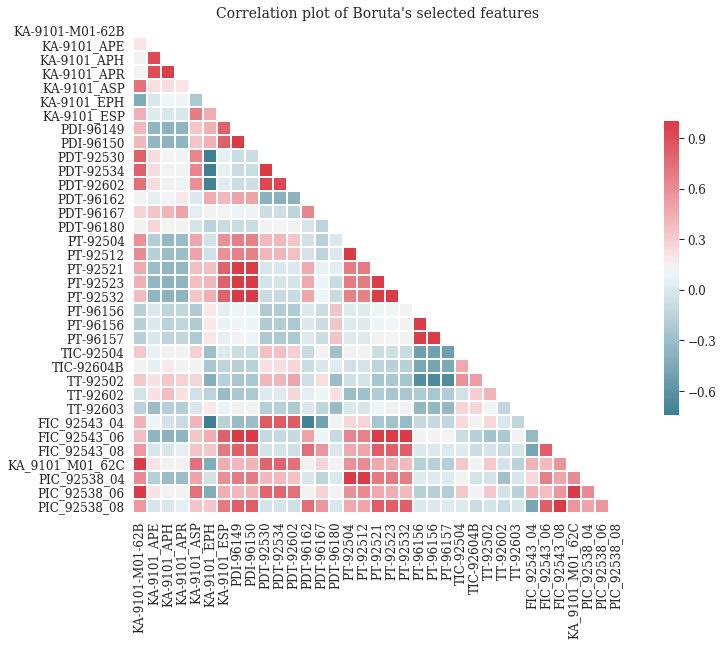

In [23]:
data_inputs = data_train[:,confirmed_inputs_idxs]

colnames = [name.split("VAL_23")[1][1:].split(":")[0] for name in confirmed_inputs]
df = pd.DataFrame(data_inputs, columns=colnames)

fig = plot_correlation(df, "Correlation plot of Boruta's selected features")
fig.show()

TODO: Comment on the correlation plot

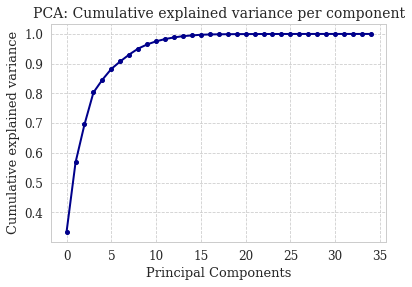

Number of components (99% var expl.): 14


In [24]:
pca = PCA().fit(data_inputs)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker="o", c="darkblue", ms=4, lw=2)
plt.title("PCA: Cumulative explained variance per component")
plt.xlabel("Principal Components")
plt.ylabel("Cumulative explained variance")
plt.show()

print("Number of components (99% var expl.):", 
      PCA(.99).fit(data_train[:,confirmed_inputs_idxs]).n_components_)

Looks like 99% of the variation in the data can be described by only 8 principal components! 

**Exporting the PCA-datasets for training, validation and testing.**

In [25]:
def transform_pca(fit_pca, data, idxs_to_transform):
    transformed = fit_pca.transform(data[:,idxs_to_transform])
    data_pca = np.hstack((data[:,:3], transformed))  
    return data_pca

idxs = confirmed_inputs_idxs
pca = PCA(.99).fit(data_inputs)

data_train_pca = transform_pca(pca, data_train, idxs)
data_valid_pca = transform_pca(pca, data_valid, idxs)
data_test_pca = transform_pca(pca, data_test, idxs)

print(data_train_pca.shape)
print(data_valid_pca.shape)
print(data_test_pca.shape)

print("Saving to file ...")
path = ROOT_PATH + "data/feature_selection/boruta/"
np.save(path + "train_bor_pca.npy", data_train_pca)
np.save(path + "valid_bor_pca.npy", data_valid_pca)
np.save(path + "test_bor_pca.npy", data_test_pca)
print("... success! ")

(53211, 17)
(17737, 17)
(17737, 17)
Saving to file ...
... success! 


---
## (2) Feature Selection by Random Forest

A second way to perform feature selection is to train a Random Forest which gives us "feature importances" for each of the features. The feature importance is decided from how often the variable has been used as a split criterion. Feature selection is done by choosing the X most important features based on the Random Forest. 

---

In [13]:
params_rf = {'n_estimators': 2000, 
             'max_depth': 5, 
             'min_samples_split': 2, 
             'max_features': 'auto', 
             'criterion': 'mse', 
             'random_state': 0, 
             'n_jobs': -1, 
             'oob_score': True,
             'verbose': 1
            }

rf = RandomForestRegressor(**params_rf)

In [14]:
rf.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1238 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1788 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  7.4min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
           oob_score=True, random_state=0, verbose=1, warm_start=False)

In [15]:
avg_imp = np.average(rf.feature_importances_)
avg_imp_gt0 = np.average(rf.feature_importances_[rf.feature_importances_ > 0])
print("Average Imp.:            ", avg_imp)
print("Average Imp. > 0:        ", avg_imp_gt0)
print("# of Feature Imp. > 0:   ",len(rf.feature_importances_[rf.feature_importances_ > 0]))
print("# of Feature Imp. > avg: ",len(rf.feature_importances_[rf.feature_importances_ > avg_imp]))

Average Imp.:             0.010526315789473679
Average Imp. > 0:         0.01999999999999999
# of Feature Imp. > 0:    50
# of Feature Imp. > avg:  8


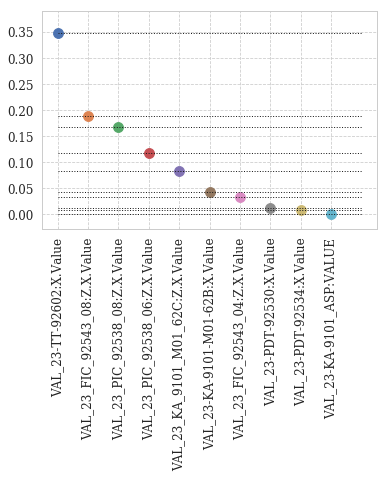

Most important features by Random Forest:


Tag  Value
0           VAL_23-TT-92602:X.Value  0.347
1     VAL_23_FIC_92543_08:Z.X.Value  0.188
2     VAL_23_PIC_92538_08:Z.X.Value  0.167
3     VAL_23_PIC_92538_06:Z.X.Value  0.116
4  VAL_23_KA_9101_M01_62C:Z.X.Value  0.083
5    VAL_23-KA-9101-M01-62B:X.Value  0.043
6     VAL_23_FIC_92543_04:Z.X.Value  0.033
7          VAL_23-PDT-92530:X.Value  0.011
8          VAL_23-PDT-92534:X.Value  0.008
9          VAL_23-KA-9101_ASP:VALUE  0.001

In [26]:
headers_imp = list(zip(headers[3:],rf.feature_importances_))
headers_imp_sorted = sorted(headers_imp, key=lambda tag: tag[1], reverse=True)
headers_imp_filtered = list(filter(lambda elem: elem[1] > 5e-4, headers_imp_sorted))

plt.figure()
for i in range(len(headers_imp_filtered)):
    tag, val = headers_imp_filtered[i]
    #plt.bar(x=i,height=val,label=tag)
    plt.scatter(x=i, y=val, label=tag, s=100)
    plt.hlines(y=val,xmin=0,xmax=len(headers_imp_filtered), linestyle="dotted", lw=1.0)

xticks = [tup[0] for tup in headers_imp_filtered]
plt.xticks(range(len(xticks)), xticks, rotation=90)
plt.show()

print("Most important features by Random Forest:")
rf_df = pd.DataFrame({"Tag":   [tup[0] for tup in headers_imp_filtered], 
              "Value": [round(tup[1],3) for tup in headers_imp_filtered]})
rf_df

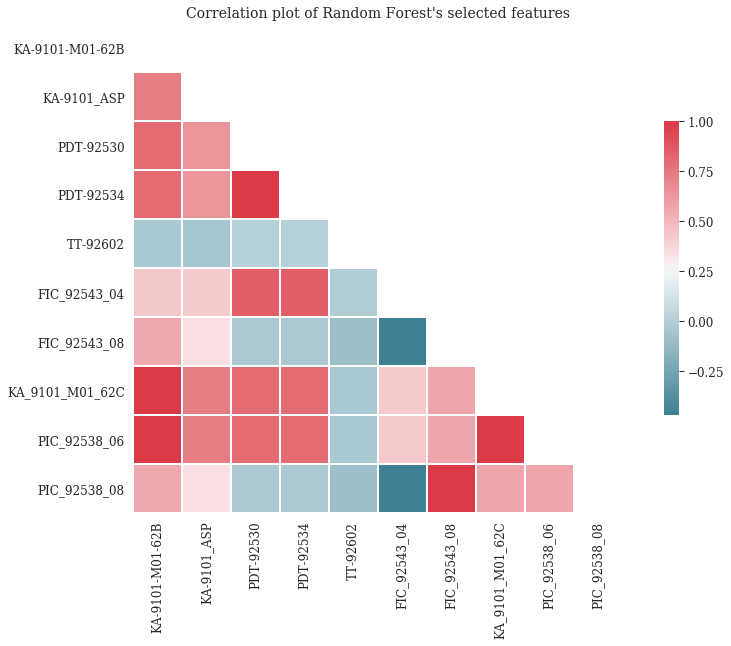

In [27]:
rf_confirmed_tags = sorted(rf_df["Tag"].values)
rf_confirmed_idxs = [np.where(headers==tag)[0][0] for tag in rf_confirmed_tags]

data = data_train[:,rf_confirmed_idxs]
colnames = [name.split("VAL_23")[1][1:].split(":")[0] for name in rf_confirmed_tags]
df = pd.DataFrame(data, columns=colnames)

fig = plot_correlation(df, "Correlation plot of Random Forest's selected features")
fig.show()

#### Export results

In [33]:
rf_all_idxs = np.concatenate((range(3), rf_confirmed_idxs))
tags_df = pd.DataFrame(np.hstack((np.expand_dims(rf_confirmed_tags, axis=1), 
                                  np.expand_dims(rf_confirmed_idxs, axis=1))), 
                       columns=["Tag", "Index"])

train_rf = data_train[:,rf_all_idxs]
valid_rf = data_valid[:,rf_all_idxs]
test_rf = data_test[:, rf_all_idxs]

print(train_rf.shape)
print(valid_rf.shape)
print(test_rf.shape)

path = ROOT_PATH + "data/metadata/tags/"
tags_df.to_csv(path + "selected_tags_rf.csv", index=False)

path = ROOT_PATH + "data/feature_selection/rf/"
print("Saving to file ...")
np.save(path + "train_rf.npy", train_rf)
np.save(path + "valid_rf.npy", valid_rf)
np.save(path + "test_rf.npy", test_rf)
print("... success!")

(53211, 13)
(17737, 13)
(17737, 13)
Saving to file ...
... success!


### PCA on the RF-features

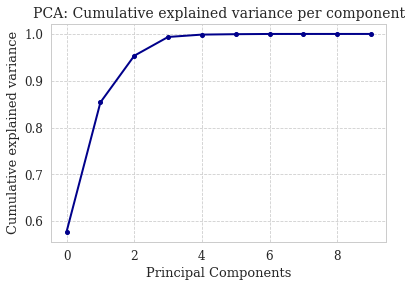

Number of components (99% var expl.): 4


In [29]:
pca = PCA().fit(data_train[:,rf_confirmed_idxs])

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker="o", c="darkblue", ms=4, lw=2)
plt.title("PCA: Cumulative explained variance per component")
plt.xlabel("Principal Components")
plt.ylabel("Cumulative explained variance")
plt.show()

print("Number of components (99% var expl.):", PCA(.99).fit(data_train[:,rf_confirmed_idxs]).n_components_)

In [30]:
idxs = rf_confirmed_idxs
pca = PCA(.99).fit(data_train[:,idxs])

rf_train_pca = transform_pca(pca, data_train, idxs)
rf_valid_pca = transform_pca(pca, data_valid, idxs)
rf_test_pca = transform_pca(pca, data_test, idxs)

print(rf_train_pca.shape)
print(rf_valid_pca.shape)
print(rf_test_pca.shape)

print("Saving to file ...")
path = ROOT_PATH + "data/feature_selection/rf/"
np.save(path + "train_rf_pca.npy", rf_train_pca)
np.save(path + "valid_rf_pca.npy", rf_valid_pca)
np.save(path + "test_rf_pca.npy", rf_test_pca)
print("... success! ")

(53211, 7)
(17737, 7)
(17737, 7)
Saving to file ...
... success! 
